In [ ]:
while True : pass

In [1]:
!pip install -r requirements.txt

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 169.1 MB 40 kB/s 
     |████████████████████████████████| 66.3 MB 34 kB/s 
     |████████████████████████████████| 66.2 MB 12 kB/s 
     |████████████████████████████████| 23.2 MB 31 kB/s 
     |████████████████████████████████| 15.7 MB 17 kB/s 
     |████████████████████████████████| 22.1 MB 1.3 MB/s 
     |████████████████████████████████| 17.6 MB 49 kB/s 
     |████████████████████████████████| 17.3 MB 36 kB/s 
     |████████████████████████████████| 17.3 MB 16 kB/s 
     |████████████████████████████████| 13.3 MB 124 kB/s 
     |████████████████████████████████| 17.4 MB 121 kB/s 
     |████████████████████████████████| 17.6 MB 7.4 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvi

In [2]:
from PIL import Image
import torch
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import pickle

In [3]:
class Dataset():
    def __init__(self):
        self.labels,self.images = self.load_data() 

    # To load images and labels for dataloader
    def load_data(self):
        transform_data = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
        trainset = torchvision.datasets.CIFAR10(
            root='./', train=True, download=True, transform=transform_data)
        trainloader = torch.utils.data.DataLoader(
            trainset, batch_size=64, shuffle=True, num_workers=2)

        labels={}
        images = {}
        count = 0
        for batch, (x, y) in enumerate(trainloader):
              for i in range(len(x)):
                  if(y[i] > 7):
                      images[count]=x[i]
                      labels[count]=y[i]-8
                      count+=1
        return labels,images

    def __len__(self):
        return len(self.labels)
    

    # To return x,y values in each iteration over dataloader as batches.
    def __getitem__(self, idx):
        return (
            self.images[idx],
            self.labels[idx],
        )
        

In [4]:
# Inheriting from Dataset class
class ValDataset(Dataset):

    def load_data(self):
          transform_data = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
          ])

          testset = torchvision.datasets.CIFAR10(root='./', train=False, download=True, transform=transform_data)
          testloader = torch.utils.data.DataLoader(
              testset, batch_size=64, shuffle=False, num_workers=2)
          labels={}
          images = {}
          count = 0
          for batch, (x, y) in enumerate(testloader):
              for i in range(len(x)):
                  if(y[i] > 7):
                      images[count]=x[i]
                      labels[count]=y[i]-8
                      count+=1
          return labels,images


In [5]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        # CNNs for rgb images
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        # Connecting CNN outputs with Fully Connected layers
        self.fc1 = nn.Linear(in_features=12*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=1)

    def forward(self, t):
        t = t

        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = t.reshape(-1, 12*5*5)
        t = self.fc1(t)
        t = F.relu(t)

        t = self.fc2(t)
        t = F.relu(t)

        t = torch.sigmoid(self.out(t))

        return t

In [22]:
# Function to return number of correct predictions in a batch
def get_num_correct(preds,labels):
    return torch.round(preds).eq(labels).sum().item()

In [31]:
def train(model):
    model.train()

    # Defining the loss and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_of_epochs = 50
    epochs = []
    losses = []
    # dataloader in pytorch to load validation and train dataset
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=64,shuffle=True)
    testloader = torch.utils.data.DataLoader(valdataset, batch_size=32,shuffle=True)
    for epoch in range(num_of_epochs):
        cnt = 0
        tot_loss = 0
        tot_correct = 0
        tot_test = 0
        for batch, (x, y) in enumerate(trainloader):
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            y_pred = model(x)
            y=(torch.unsqueeze(y, 1)).to(torch.float32)
            # Compute loss (here CrossEntropyLoss)
            loss = F.binary_cross_entropy(y_pred,y)

            loss.backward()
            optimizer.step()

        for batch, (x, y) in enumerate(testloader):
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            with torch.no_grad():
                y_pred = model(x)
                # Compute loss (here CrossEntropyLoss)
                y=(torch.unsqueeze(y, 1)).to(torch.float32)
                loss = F.binary_cross_entropy(y_pred,y)

            tot_loss+=loss.item()
            tot_correct +=get_num_correct(y_pred,y)
            tot_test+= len(y)
        epochs.append(epoch)
        losses.append(tot_loss)
        print("Epoch",epoch," accuracy",(tot_correct/tot_test)*100," total_correct",tot_correct," loss:",tot_loss)
        if(epoch%5==4):
            torch.save(model.state_dict(), "models/model001_ep"+str(epoch+1)+".pth")

    # Plot a Validation Loss vs Epochs graph 
    plt.plot(epochs, losses, color='green', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=8) 
    plt.xlabel('epochs ---->',color='m',fontsize='xx-large' ) 
    plt.ylabel('loss ------>',color='m',fontsize='xx-large') 
    axes = plt.gca()        # 'gca' - get current axes
    axes.set_facecolor('c') #'c' - cyan
    axes.tick_params(axis='y', which='both', colors='tomato')
    axes.tick_params(axis='x', which='both', colors='#20ff14')
    plt.title("Val Loss vs Epoch",color='m',fontsize='xx-large')

In [8]:
dataset = Dataset()
valdataset = ValDataset()


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


Epoch 0  accuracy 84.1  total_correct 1682  loss: 22.90340830385685
Epoch 1  accuracy 86.45  total_correct 1729  loss: 19.837316654622555
Epoch 2  accuracy 89.05  total_correct 1781  loss: 16.136321529746056
Epoch 3  accuracy 90.75  total_correct 1815  loss: 15.398405708372593
Epoch 4  accuracy 91.45  total_correct 1829  loss: 13.625281367450953
Epoch 5  accuracy 90.25  total_correct 1805  loss: 16.686705704778433
Epoch 6  accuracy 92.0  total_correct 1840  loss: 12.613580100238323
Epoch 7  accuracy 91.3  total_correct 1826  loss: 13.411115296185017
Epoch 8  accuracy 91.05  total_correct 1821  loss: 14.421838704496622
Epoch 9  accuracy 91.8  total_correct 1836  loss: 12.371410941705108
Epoch 10  accuracy 91.55  total_correct 1831  loss: 14.289502128958702
Epoch 11  accuracy 92.10000000000001  total_correct 1842  loss: 13.034926263615489
Epoch 12  accuracy 92.35  total_correct 1847  loss: 13.957462472841144
Epoch 13  accuracy 92.2  total_correct 1844  loss: 14.584883127361536
Epoch 14  

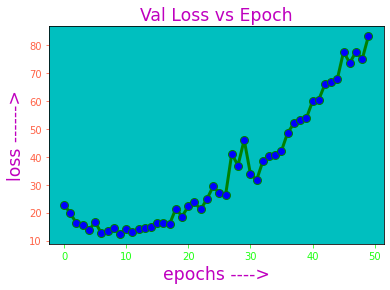

In [32]:
model = Network()
train(model)

In [33]:
# Saving labels to label value as a json
reference = {'ship':0,'truck':1}
with open('labels.json', 'wb') as iw:
    pickle.dump(reference, iw)

In [ ]:
# prediction function to test
def predict(img_path):
    image = Image.open(img_path)
    image = ToTensor()(image)
    resize = transforms.Compose([transforms.Resize((256,256))])
    y_result = model(resize(image).unsqueeze(0))
    result_idx = y_result.argmax(dim=1)
    for key,value in reference.items():
        if(value==result_idx):
            print(key)
            break